In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from scipy.integrate import trapezoid
import pandas as pd

In [2]:
def logistic_4p(x, min, max, ec50, h):
    return min + (max - min)/(1 + (x/ec50)**h)

In [3]:
def abs_ec50(min, max, ec50, h):
    return (((max - min)/(50 - min) - 1)**(1/h))*ec50

In [4]:
# define concentration series; 2-fold dilution
conc_range = [2e-8, 20e-6]
x = np.geomspace(*conc_range, 11)
x_fit = np.geomspace(*conc_range, 1000)
auc_conc = np.geomspace(1e-9, 5e-6, 1000) # AUC is quantified up to 5 uM

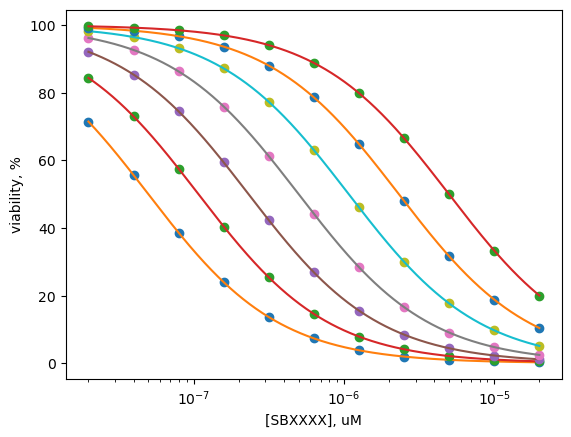

In [5]:
# all compounds are tested with the same dilution series
# create a range of perfect curves; quantify AUC over the whole concentration range
plt.xscale("log")
plt.xlabel('[SBXXXX], uM')
plt.ylabel('viability, %')
areas = []
for ec50 in np.geomspace(5e-8, 5e-6, 7):
    plt.plot(x, logistic_4p(x, 0, 100, ec50, 1), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, 0, 100, ec50, 1))
    area = trapezoid(logistic_4p(auc_conc, 0, 100, ec50, 1), auc_conc)
    areas.append(area)

In [6]:
# to normalize over the tested concentration range and express AUC as a fractional value
area_control = 100*(auc_conc[-1] - auc_conc[0])

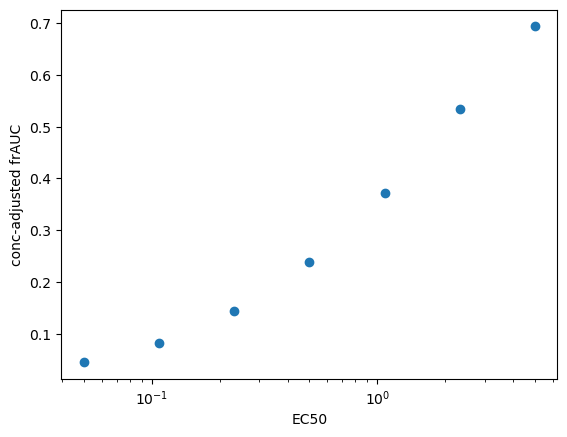

In [7]:
plt.xscale('log')
plt.xlabel('EC50')
plt.ylabel('conc-adjusted frAUC')
plt.plot(np.geomspace(5e-2, 5, 7),[area / area_control for area in areas], 'o')

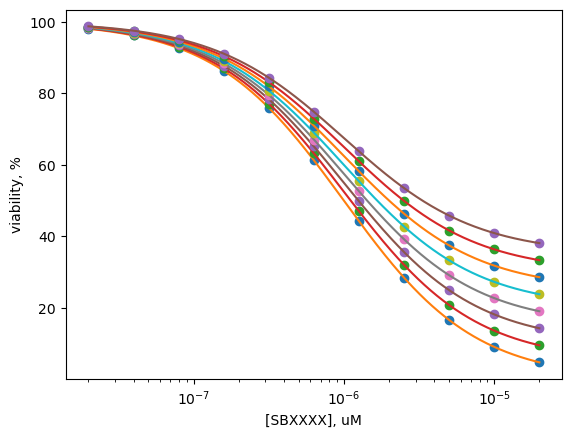

In [8]:
# bad curves: lower plateue differs for the same potency of 1 uM
# here we also quantify absolute ec50 values
plt.xscale("log")
plt.xlabel('[SBXXXX], uM')
plt.ylabel('viability, %')
areas = []
abs_ec50s = []
for min in np.linspace(0, 35, 8):
    plt.plot(x, logistic_4p(x, min, 100, 1e-6, 1), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, min, 100, 1e-6, 1))
    area = trapezoid(logistic_4p(auc_conc, min, 100, 1e-6, 1), auc_conc)
    areas.append(area)
    abs_ec50s.append(abs_ec50(min, 100, 1e-6, 1))

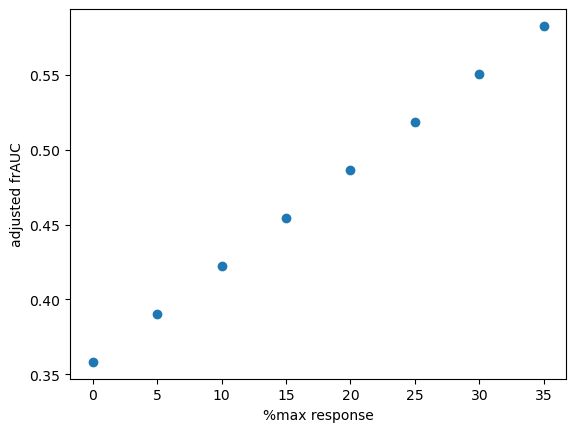

In [9]:
plt.xlabel('%max response')
plt.ylabel('adjusted frAUC')
plt.plot(np.linspace(0, 35, 8),[area / area_control for area in areas], 'o')
# AUC depends linearly from min - not a big surprise
# effect is not as strong, as for potency differences.
# AUC does not disciminate well between cytotox vs cytostatic/precipitation?
# Indeed it does not, since there are not enough concentration points at lower plateue region to inflate AUCs for bad curves

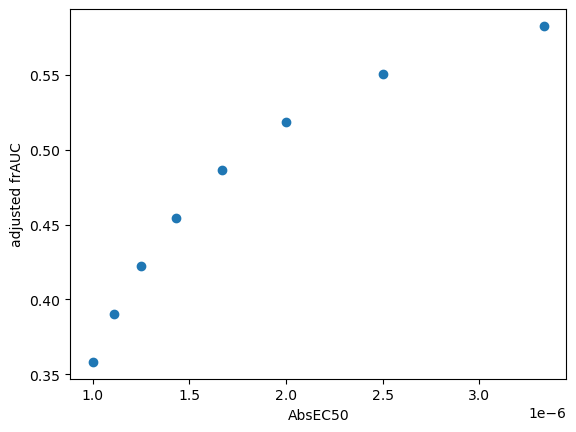

In [10]:
# A question - how does it correlate with the absolute EC50?
plt.xlabel('AbsEC50')
plt.ylabel('adjusted frAUC')
plt.plot(abs_ec50s,[area / area_control for area in areas], 'o')
# the effect is not that strong either.

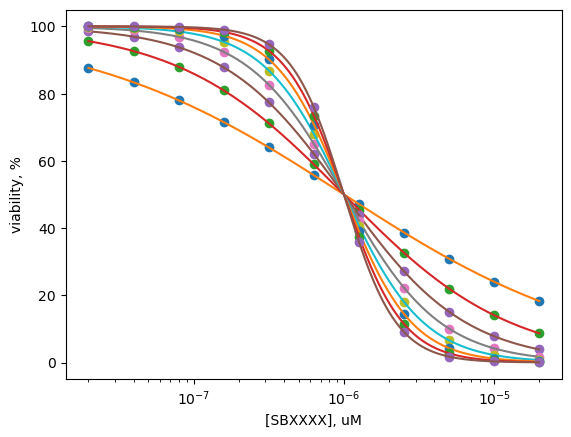

In [11]:
# bad curves: slope coefficient differs, potency same - 1 uM
plt.xscale("log")
plt.xlabel('[SBXXXX], uM')
plt.ylabel('viability, %')
areas = []
for h in np.linspace(0.5, 2.5, 8):
    plt.plot(x, logistic_4p(x, 0, 100, 1e-6, h), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, 0, 100, 1e-6, h))
    area = trapezoid(logistic_4p(auc_conc, 0, 100, 1e-6, h), auc_conc)
    areas.append(area)

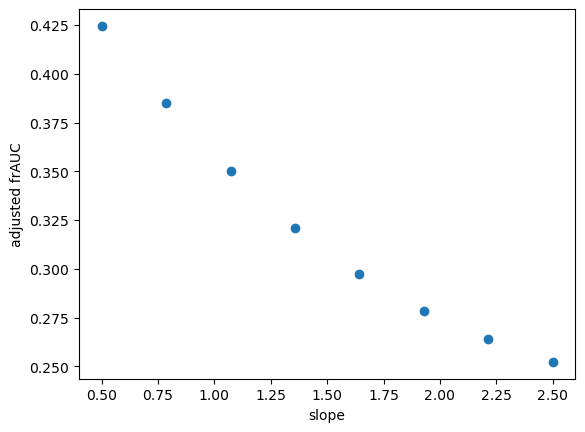

In [12]:
plt.xlabel('slope')
plt.ylabel('adjusted frAUC')
plt.plot(np.linspace(0.5, 2.5, 8),[area / area_control for area in areas], 'o')
# The effect of Hill-alike factor on AUC would be minimal if AUC is quantified 
# till higher conc, but for the shallow curves the values are inflated when the
# constrain is far from plateau
# If steep responses are ok for phenotyp readouts, remains a question.

In [13]:
# Let's generate a set of curves with values from a uniform distribution
# min from 0 to 50, h from 0.5 to 2.5, ec50 from 100 to 10000 nM

In [14]:
parameters = []
for i in range(0,1000):
    parameters.append([np.random.uniform(0,50), 100, np.random.uniform(1e-7,1e-5), np.random.uniform(0.5,2.5)])

In [15]:
all_data = pd.DataFrame()

In [16]:
all_data['Parameters'] = parameters

In [17]:
areas = []
for i in range(0,1000):
    area = trapezoid(logistic_4p(auc_conc, *all_data['Parameters'][i]), auc_conc)
    areas.append(area)

In [18]:
fr_areas = [area / area_control for area in areas]

In [19]:
all_data['Adjusted frAUC'] = fr_areas

In [20]:
def starred_abs_ec50(set):
    return abs_ec50(*set)

In [21]:
all_data['min'] = all_data['Parameters'].apply(lambda value: value[0])
all_data['max'] = all_data['Parameters'].apply(lambda value: value[1])
all_data['EC50'] = all_data['Parameters'].apply(lambda value: value[2])
all_data['h'] = all_data['Parameters'].apply(lambda value: value[3])
all_data['absEC50'] = all_data['Parameters'].apply(starred_abs_ec50)

In [22]:
all_data

,Parameters,Adjusted frAUC,min,max,EC50,h,absEC50
0,"[40.547242188911916, 100, 8.631265476866948e-0...",0.961507,40.547242,100,0.000009,2.479688,0.000017
1,"[24.757311493507128, 100, 5.234772973450444e-0...",0.831298,24.757311,100,0.000005,1.699914,0.000008
2,"[44.21364388122298, 100, 8.337770364703633e-06...",0.953114,44.213644,100,0.000008,2.224267,0.000022
3,"[15.165333759898664, 100, 1.8687238767196436e-...",0.532312,15.165334,100,0.000002,2.147099,0.000002
4,"[44.477841726091754, 100, 3.8628888121764806e-...",0.810913,44.477842,100,0.000004,1.211529,0.000024
...,...,...,...,...,...,...,...
995,"[28.18223093012983, 100, 8.361008865031073e-06...",0.918747,28.182231,100,0.000008,1.820081,0.000013
996,"[14.974000605050103, 100, 9.371675772435628e-0...",0.907461,14.974001,100,0.000009,1.667049,0.000012
997,"[19.689810164254073, 100, 7.193919569017709e-0...",0.808628,19.689810,100,0.000007,1.015062,0.000012
998,"[23.21523548301761, 100, 6.708186468673798e-06...",0.900674,23.215235,100,0.000007,2.156643,0.000009


In [23]:
# top 10 compounds with lowest absEC50
top10_absec50 = all_data.sort_values(by='absEC50').head(10)

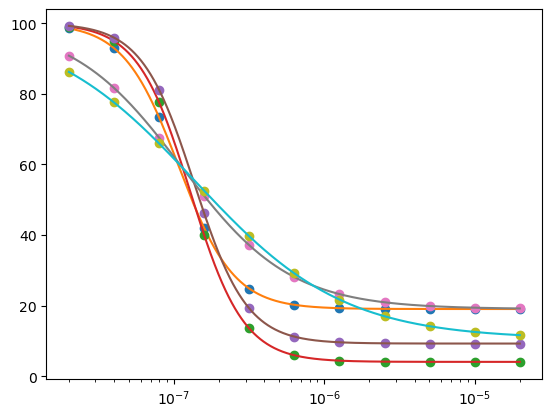

In [24]:
plt.xscale('log')
for i in range(0, 5):
    plt.plot(x, logistic_4p(x, *top10_absec50['Parameters'].iloc[i]), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, *top10_absec50['Parameters'].iloc[i]))    

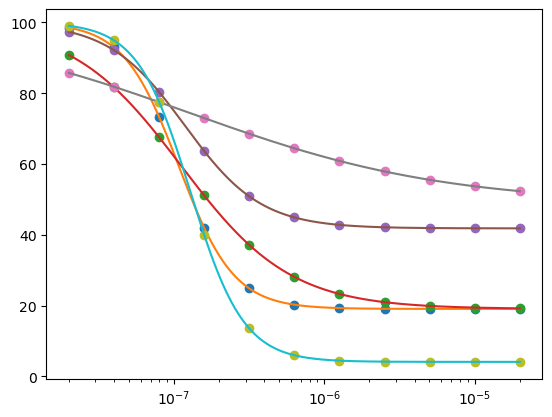

In [25]:
# top 10 compounds with lowest EC50
top10_ec50 = all_data.sort_values(by='EC50').head(10)
plt.xscale('log')
for i in range(0, 5):
    plt.plot(x, logistic_4p(x, *top10_ec50['Parameters'].iloc[i]), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, *top10_ec50['Parameters'].iloc[i]))   

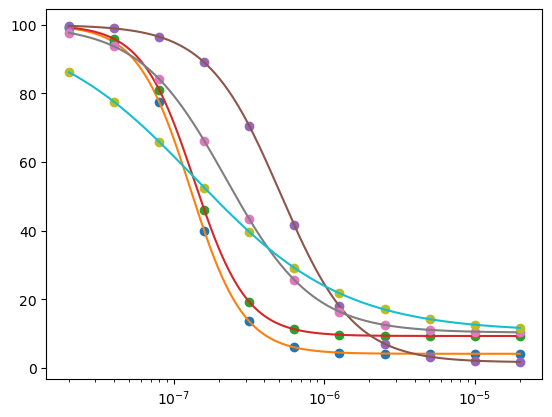

In [26]:
# top 10 compounds with lowest frAUC
top10_frauc = all_data.sort_values(by='Adjusted frAUC').head(10)
plt.xscale('log')
for i in range(0, 5):
    plt.plot(x, logistic_4p(x, *top10_frauc['Parameters'].iloc[i]), 'o')
    plt.plot(x_fit, logistic_4p(x_fit, *top10_frauc['Parameters'].iloc[i]))   

In [27]:
top10_ec50

,Parameters,Adjusted frAUC,min,max,EC50,h,absEC50
184,"[19.056802165897313, 100, 1.0743151767215846e-...",0.214109,19.056802,100,1.074315e-07,2.370174,1.315406e-07
767,"[19.053193404921686, 100, 1.1160565133891369e-...",0.243180,19.053193,100,1.116057e-07,1.194478,1.667698e-07
735,"[41.81267016641654, 100, 1.1805346234427243e-0...",0.442771,41.812670,100,1.180535e-07,1.713426,3.393972e-07
765,"[48.74394276598624, 100, 1.2854219070156278e-0...",0.596998,48.743943,100,1.285422e-07,0.512783,1.695101e-04
844,"[4.0879143623487435, 100, 1.2897582396180045e-...",0.073612,4.087914,100,1.289758e-07,2.461311,1.335237e-07
32,"[9.275235365303224, 100, 1.3641083165952247e-0...",0.125331,9.275235,100,1.364108e-07,2.483661,1.481590e-07
745,"[40.00432840452279, 100, 1.369367006910883e-07...",0.452285,40.004328,100,1.369367e-07,1.096027,5.948697e-07
574,"[10.54539530372926, 100, 1.3837423333840898e-0...",0.211967,10.545395,100,1.383742e-07,0.879760,1.811288e-07
992,"[11.30514093477708, 100, 1.4011719756267524e-0...",0.272600,11.305141,100,1.401172e-07,0.631231,2.103004e-07
623,"[39.53521336307141, 100, 1.554692526834937e-07...",0.448771,39.535213,100,1.554693e-07,1.167229,5.937034e-07


In [28]:
top10_absec50

,Parameters,Adjusted frAUC,min,max,EC50,h,absEC50
184,"[19.056802165897313, 100, 1.0743151767215846e-...",0.214109,19.056802,100,1.074315e-07,2.370174,1.315406e-07
844,"[4.0879143623487435, 100, 1.2897582396180045e-...",0.073612,4.087914,100,1.289758e-07,2.461311,1.335237e-07
32,"[9.275235365303224, 100, 1.3641083165952247e-0...",0.125331,9.275235,100,1.364108e-07,2.483661,1.481590e-07
767,"[19.053193404921686, 100, 1.1160565133891369e-...",0.243180,19.053193,100,1.116057e-07,1.194478,1.667698e-07
574,"[10.54539530372926, 100, 1.3837423333840898e-0...",0.211967,10.545395,100,1.383742e-07,0.879760,1.811288e-07
992,"[11.30514093477708, 100, 1.4011719756267524e-0...",0.272600,11.305141,100,1.401172e-07,0.631231,2.103004e-07
380,"[23.24455768245468, 100, 1.8330095578300967e-0...",0.274944,23.244558,100,1.833010e-07,2.030553,2.494024e-07
425,"[10.253992861206818, 100, 2.220670656649325e-0...",0.181631,10.253993,100,2.220671e-07,1.506799,2.586041e-07
460,"[2.042086706834989, 100, 2.8473159129983107e-0...",0.227792,2.042087,100,2.847316e-07,0.770856,3.005583e-07
645,"[26.512248628338252, 100, 2.3263187001043687e-...",0.313881,26.512249,100,2.326319e-07,2.181227,3.289290e-07


In [29]:
top10_frauc

,Parameters,Adjusted frAUC,min,max,EC50,h,absEC50
844,"[4.0879143623487435, 100, 1.2897582396180045e-...",0.073612,4.087914,100,1.289758e-07,2.461311,1.335237e-07
32,"[9.275235365303224, 100, 1.3641083165952247e-0...",0.125331,9.275235,100,1.364108e-07,2.483661,1.481590e-07
711,"[1.584657854017052, 100, 5.109919037649337e-07...",0.174919,1.584658,100,5.109919e-07,1.780430,5.203194e-07
425,"[10.253992861206818, 100, 2.220670656649325e-0...",0.181631,10.253993,100,2.220671e-07,1.506799,2.586041e-07
574,"[10.54539530372926, 100, 1.3837423333840898e-0...",0.211967,10.545395,100,1.383742e-07,0.879760,1.811288e-07
184,"[19.056802165897313, 100, 1.0743151767215846e-...",0.214109,19.056802,100,1.074315e-07,2.370174,1.315406e-07
802,"[7.250861705004508, 100, 5.196986200805318e-07...",0.221680,7.250862,100,5.196986e-07,1.835579,5.660051e-07
460,"[2.042086706834989, 100, 2.8473159129983107e-0...",0.227792,2.042087,100,2.847316e-07,0.770856,3.005583e-07
767,"[19.053193404921686, 100, 1.1160565133891369e-...",0.243180,19.053193,100,1.116057e-07,1.194478,1.667698e-07
229,"[9.436223463519639, 100, 3.237169517379071e-07...",0.250575,9.436223,100,3.237170e-07,1.054155,3.947578e-07


In [30]:
absec50_and_frauc = top10_absec50.index.intersection(top10_frauc.index)
absec50_and_frauc

Index([184, 844, 32, 767, 574, 425, 460], dtype='int64')

In [31]:
ec50_and_frauc = top10_ec50.index.intersection(top10_frauc.index)
ec50_and_frauc

Index([184, 767, 844, 32, 574], dtype='int64')

In [32]:
absec50_and_ec50 = top10_absec50.index.intersection(top10_ec50.index)
absec50_and_ec50

Index([184, 844, 32, 767, 574, 992], dtype='int64')